In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from Image_Functions import *
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import random
%matplotlib inline

# this notebook is used exclusively for training the model
#load the images
vehicle_images = glob.glob('vehicles\*\*.png')
non_vehicle_images = glob.glob('non-vehicles\*\*.png')

cars = []
notcars = []

for vehicle_image in vehicle_images:
    cars.append(vehicle_image)
for non_vehicle_image in non_vehicle_images:
    notcars.append(non_vehicle_image)





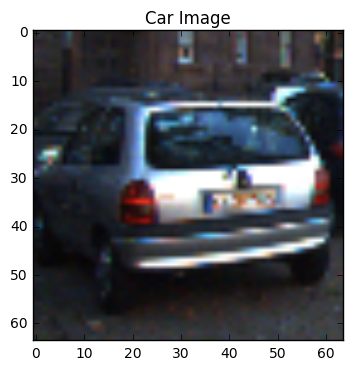

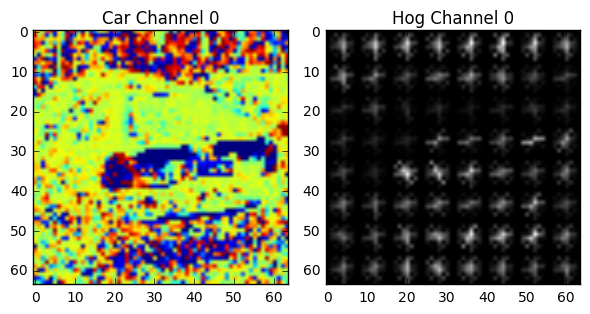

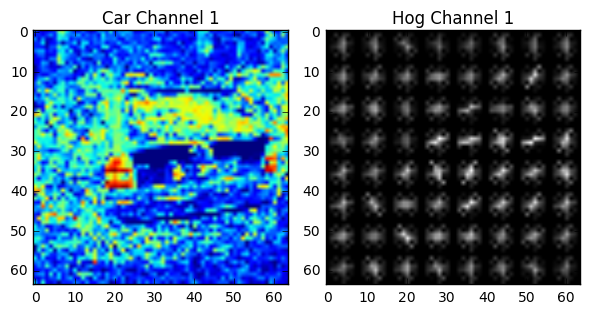

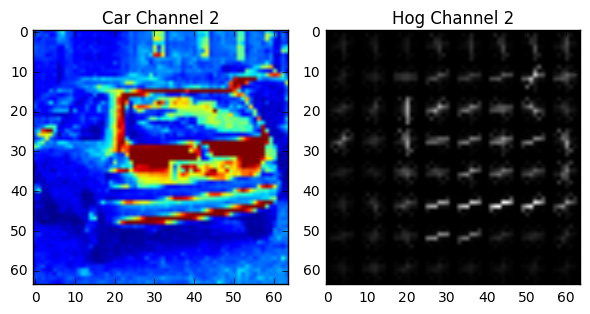

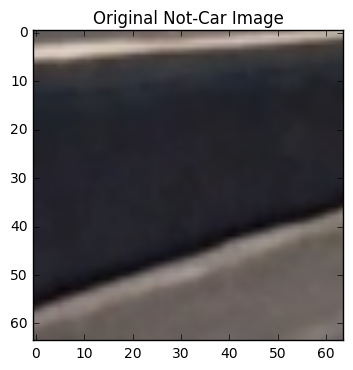

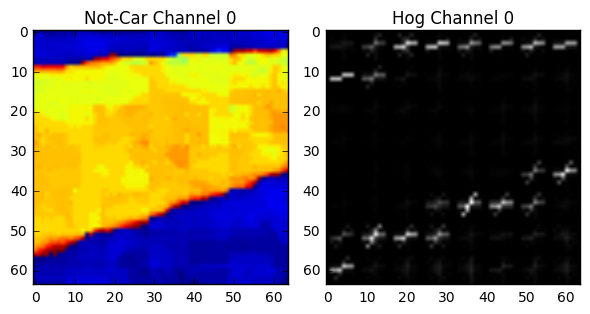

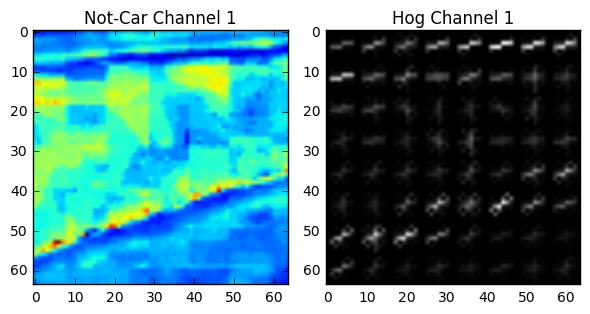

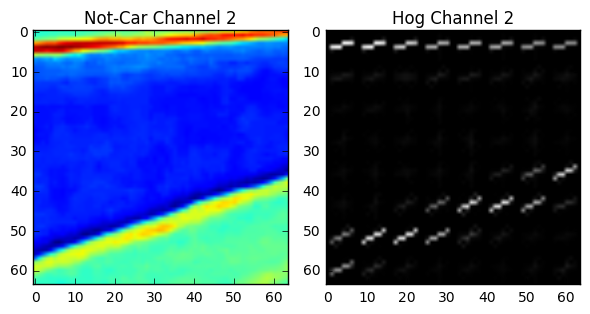

In [14]:
#Reduce the sample size if desired

#sample_size = 1000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
#edit parameters

color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
vis = True

def visualize_hog(img, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        hog_feat=True):
    # Create a list to append feature vectors to
    # Iterate through the list of images
    # Read in each one by one
    image = mpimg.imread(img)
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            hog_images = []
            hog_images_temp = []
            for channel in range(feature_image.shape[2]):
                hog_features, hog_images_temp = (get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                   vis=True, feature_vec=True))
                hog_images.append(hog_images_temp)
            hog_features = np.ravel(hog_features)        
        else:
            hog_features, hog_images = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            # Append the new feature vector to the features list
    # Return list of feature vectors
    return feature_image, hog_images

if vis == True:
    image = random.choice(cars)
    image2 = random.choice(notcars)
    image_show, visualize = visualize_hog(image, color_space='HSV', orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        hog_feat=hog_feat)
    image_show2, visualize2 = visualize_hog(image2, color_space='HSV', orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        hog_feat=hog_feat)
    fig = plt.figure(0)
    plt.imshow(mpimg.imread(image))
    plt.title('Car Image')
    
    for i in range(len(visualize)): 
        fig = plt.figure(i+1)
        fignum = 120
        fignum +=1
        plt.subplot(fignum)
        plt.imshow(image_show[:,:,i])
        string = 'Car Channel ' + str(i)
        plt.title(string)
        fignum += 1
        plt.subplot(fignum)
        plt.imshow(visualize[i], cmap='gray')
        string = 'Hog Channel ' + str(i)
        plt.title(string)
        fig.tight_layout()
        
    fig = plt.figure(4)
    plt.imshow(mpimg.imread(image2))
    plt.title('Original Not-Car Image')
    for i in range(len(visualize)): 
        fig = plt.figure(i+5)
        fignum = 120
        fignum +=1
        plt.subplot(fignum)
        plt.imshow(image_show2[:,:,i])
        string = 'Not-Car Channel ' + str(i)
        plt.title(string)
        fignum += 1
        plt.subplot(fignum)
        plt.imshow(visualize2[i], cmap='gray')
        string = 'Hog Channel ' + str(i)
        plt.title(string)
        fig.tight_layout()




In [ ]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64) 


# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Shuffle and Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
#scaled_X, y = shuffle(scaled_X, y)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

In [4]:
from sklearn.externals import joblib

joblib.dump(svc, 'pickle_data.pkl') 
joblib.dump(X_scaler, 'scaler.pkl') 

['scaler.pkl']